# CMAP-Elites DEMO

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, axis_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions
from pcgsepy.evo.genops import expander

## Setup

In [4]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [5]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [6]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

# for k in block_definitions.keys():
#     if k != "":  # TODO: This is a probable bug, reported to the SE API devs
#         ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

In [7]:
used_ll_blocks = [
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCorner',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorSlope',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorCornerInv',
    'MyObjectBuilder_CubeBlock_LargeBlockArmorBlock',
    'MyObjectBuilder_Gyro_LargeBlockGyro',
    'MyObjectBuilder_Reactor_LargeBlockSmallGenerator',
    'MyObjectBuilder_CargoContainer_LargeBlockSmallContainer',
    'MyObjectBuilder_Cockpit_OpenCockpitLarge',
    'MyObjectBuilder_Thrust_LargeBlockSmallThrust',
    'MyObjectBuilder_InteriorLight_SmallLight',
    'MyObjectBuilder_CubeBlock_Window1x1Slope',
    'MyObjectBuilder_CubeBlock_Window1x1Flat',
    'MyObjectBuilder_InteriorLight_LargeBlockLight_1corner'
]

for k in used_ll_blocks:
    ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [8]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [9]:
rcc1 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc1.extra_args["req_tiles"] = ['cockpit']

rcc2 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc2.extra_args["req_tiles"] = ['corridorcargo', 'corridorgyros', 'corridorreactors']

rcc3 = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc3.extra_args["req_tiles"] = ['thrusters']

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

In [10]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver, names=['HeadModule', 'BodyModule', 'TailModule']
)

In [11]:
lsystem.add_hl_constraints(cs=[
    [nic, rcc1],
    [nic, rcc2],
    [nic, rcc3]
])

lsystem.add_ll_constraints(cs=[
    [sc],
    [sc],
    [sc]
])

In [12]:
expander.initialize(rules=lsystem.hl_solver.parser.rules)

## MAP-Elites

In [13]:
from pcgsepy.evo.fitness import box_filling_fitness, bounding_box_fitness, func_blocks_fitness, axis_fitness

feasible_fitnesses = [bounding_box_fitness,
                      box_filling_fitness,
                      func_blocks_fitness,
                      axis_fitness]

In [14]:
from pcgsepy.common.vecs import Orientation, Vec
from pcgsepy.lsystem.structure_maker import LLStructureMaker
from pcgsepy.structure import Structure


def get_structure(axiom, extra_args):
    base_position, orientation_forward, orientation_up = Vec.v3i(
        0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
    structure = Structure(origin=base_position,
                          orientation_forward=orientation_forward,
                          orientation_up=orientation_up)
    structure = LLStructureMaker(atoms_alphabet=extra_args['alphabet'],
                                 position=base_position).fill_structure(
                                     structure=structure,
                                     axiom=axiom,
                                     additional_args={})
    structure.update(origin=base_position,
                     orientation_forward=orientation_forward,
                     orientation_up=orientation_up)
    return structure

In [15]:
from typing import List, Tuple
from pcgsepy.lsystem.solution import CandidateSolution


BIN_POP_SIZE = 5
CS_MAX_AGE = 10


class MAPBin:
    def __init__(self,
                 bin_idx: Tuple[int, int],
                 bin_size: Tuple[float, float]):
        self._feasible = []
        self._infeasible = []
        self.bin_idx = bin_idx
        self.bin_size = bin_size

    def __str__(self) -> str:
        vmin = (self.bin_idx[0] * self.bin_size[0], self.bin_idx[1] * self.bin_size[1])
        vmax = (vmin[0] + self.bin_size[0], vmin[1] + self.bin_size[1])
        return f'Bin {vmin}-{vmax} w/ {len(self._feasible)}f and {len(self._infeasible)}i cs'

    def __repr__(self) -> str:
        return str(self)

    def _reduce_pop(self,
                    pop: List[CandidateSolution],
                    maximize: bool = True) -> List[CandidateSolution]:
        if len(pop) > BIN_POP_SIZE:
            pop.sort(key=lambda x: x.c_fitness, reverse=maximize)
            pop = pop[:BIN_POP_SIZE]
        return pop

    def insert_cs(self,
                  cs: CandidateSolution):
        if cs.is_feasible:
            if cs not in self._feasible:
                self._feasible.append(cs)
                self._feasible = self._reduce_pop(self._feasible)
        else:
            if cs not in self._infeasible:
                self._infeasible.append(cs)
                self._infeasible = self._reduce_pop(self._infeasible,
                                                    maximize=False)

    def age_up(self):
        for pop in [self._feasible, self._infeasible]:
            for cs in pop:
                cs.age -= 1

    def remove_old(self):
        to_rem_f = [x for x in self._feasible if x.age <= 0]
        for cs in to_rem_f:
            self._feasible.remove(cs)
        to_rem_i = [x for x in self._infeasible if x.age <= 0]
        for cs in to_rem_i:
            self._infeasible.remove(cs)

    def get_metric(self,
                   metric: str,
                   use_mean: bool = True,
                   population: str = 'feasible'):
        op = np.mean if use_mean else np.max
        pop = self._feasible if population == 'feasible' else self._infeasible
        if metric == 'fitness':
            return op([cs.c_fitness for cs in pop]) if len(pop) > 0 else 0.
        elif metric == 'age':
            return op([cs.age for cs in pop]) if len(pop) > 0 else 0.
        elif metric == 'size':
            return len(pop)
        else:
            raise NotImplementedError(f'Unrecognized metric {metric}')


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pcgsepy.fi2pop.utils import create_new_pool
import random
from typing import Any, Dict, List
from tqdm.notebook import trange
from pcgsepy.fi2pop.utils import subdivide_axioms


class MAPElites:

    def __init__(self,
                 behavior_limits: Tuple[int, int] = (20, 20),
                 n_bins: Tuple[int, int] = (8, 8)):
        self.limits = behavior_limits
        self.bin_qnt = n_bins
        self.bin_sizes = (self.limits[0] / self.bin_qnt[0],
                          self.limits[1] / self.bin_qnt[1])

        self.bins = np.empty(shape=self.bin_qnt, dtype=object)
        for i in range(self.bin_qnt[0]):
            for j in range(self.bin_qnt[1]):
                self.bins[i, j] = MAPBin(bin_idx=(i, j),
                                         bin_size=self.bin_sizes)

    def show_fitness(self,
                     show_mean: bool = True,
                     population: str = 'feasible'):
        disp_map = np.zeros(shape=self.bins.shape)
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                disp_map[i, j] = self.bins[i, j].get_metric(metric='fitness',
                                                            use_mean=show_mean,
                                                            population=population)
        plt.imshow(disp_map,
                   origin='lower',
                   cmap='hot',
                   interpolation='nearest',
                   vmin=0,
                   vmax=4.5 if population == 'feasible' else 2)
        plt.xticks(np.arange(self.bin_qnt[0]),
                   np.arange(0, self.limits[0], self.bin_sizes[0]))
        plt.yticks(np.arange(self.bin_qnt[1]),
                   np.arange(0, self.limits[1], self.bin_sizes[1]))
        plt.xlabel('Largest / Smallest')
        plt.ylabel('Largest / Medium')
        plt.title(f'CMAP-Elites ({population})')
        cbar = plt.colorbar()
        cbar.set_label(f'Cumulative fitness ({"mean" if show_mean else "max"})',
                       rotation=270)
        plt.show()

    def show_age(self,
                 show_mean: bool = True,
                 population: str = 'feasible'):
        disp_map = np.zeros(shape=self.bins.shape)
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                disp_map[i, j] = self.bins[i, j].get_metric(metric='age',
                                                            use_mean=show_mean,
                                                            population=population)
        plt.imshow(disp_map,
                   origin='lower',
                   cmap='hot',
                   interpolation='nearest',
                   vmin=0,
                   vmax=CS_MAX_AGE)
        plt.xticks(np.arange(self.bin_qnt[0]),
                   np.arange(0, self.limits[0], self.bin_sizes[0]))
        plt.yticks(np.arange(self.bin_qnt[1]),
                   np.arange(0, self.limits[1], self.bin_sizes[1]))
        plt.xlabel('Largest / Smallest')
        plt.ylabel('Largest / Medium')
        plt.title(f'CMAP-Elites ({population})')
        cbar = plt.colorbar()
        cbar.set_label(f'Solutions age ({"mean" if show_mean else "max"})',
                       rotation=270)
        plt.show()

    def show_coverage(self, population: str = 'feasible'):
        disp_map = np.zeros(shape=self.bins.shape)
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                disp_map[i, j] = self.bins[i, j].get_metric(metric='size',
                                                            population=population)
        plt.imshow(disp_map,
                   origin='lower',
                   cmap='hot',
                   interpolation='nearest',
                   vmin=0,
                   vmax=BIN_POP_SIZE)
        plt.xticks(np.arange(self.bin_qnt[0]),
                   np.arange(0, self.limits[0], self.bin_sizes[0]))
        plt.yticks(np.arange(self.bin_qnt[1]),
                   np.arange(0, self.limits[1], self.bin_sizes[1]))
        plt.xlabel('Largest / Smallest')
        plt.ylabel('Largest / Medium')
        plt.title(f'CMAP-Elites ({population})')
        cbar = plt.colorbar()
        cbar.set_label('Number of solutions', rotation=270)
        plt.show()

    def _set_behavior_descriptors(self, cs: CandidateSolution):
        volume = cs.content.as_array().shape
        largest_axis, medium_axis, smallest_axis = reversed(sorted(
            list(volume)))
        mame = largest_axis / medium_axis
        mami = largest_axis / smallest_axis
        cs.b_descs = (mame, mami)

    def compute_fitness(self, axiom: str, extra_args: Dict[str, Any]) -> float:
        return sum([f(axiom, extra_args) for f in feasible_fitnesses])

    def generate_initial_populations(
        self,
        lsystem: LSystem,
        pops_size: int = 20,
        n_retries: int = 100,
    ):
        feasible_pop, infeasible_pop = [], []
        lsystem.disable_sat_check()
        with trange(n_retries, desc='Initialization ') as iterations:
            for i in iterations:
                _, hl_axioms, _ = lsystem.apply_rules(starting_axioms=['head', 'body', 'tail'],
                                                      iterations=[1, N_ITERATIONS, 1],
                                                      create_structures=False,
                                                      make_graph=False)
                axioms_sats = subdivide_axioms(hl_axioms=hl_axioms,
                                               lsystem=lsystem)
                for axiom in axioms_sats.keys():
                    cs = CandidateSolution(string=axiom)
                    if axioms_sats[axiom]['feasible'] and len(feasible_pop) < pops_size and axiom not in feasible_pop:
                        cs.c_fitness = self.compute_fitness(axiom=lsystem.hl_to_ll(axiom=axiom),
                                                            extra_args={
                                                                'alphabet': lsystem.ll_solver.atoms_alphabet
                                                                }) + (0.5 - axioms_sats[axiom]['n_constraints_v'])
                        cs.is_feasible = True
                        feasible_pop.append(cs)
                    elif not axioms_sats[axiom]['feasible'] and len(infeasible_pop) < pops_size and axiom not in feasible_pop:
                        cs.c_fitness = axioms_sats[axiom]['n_constraints_v']
                        infeasible_pop.append(cs)
                    cs.set_content(get_structure(axiom=lsystem.hl_to_ll(axiom=axiom),
                                                 extra_args={
                                                     'alphabet': lsystem.ll_solver.atoms_alphabet
                                                     }))
                    self._set_behavior_descriptors(cs=cs)
                    cs.age = CS_MAX_AGE
                iterations.set_postfix(ordered_dict={
                    'fpop-size': f'{len(feasible_pop)}/{pops_size}',
                    'ipop-size': f'{len(infeasible_pop)}/{pops_size}'
                },
                                       refresh=True)
                if i == n_retries or (len(feasible_pop) == pops_size and
                                      len(infeasible_pop) == pops_size):
                    break
        self._update_bins(lcs=feasible_pop)
        self._update_bins(lcs=infeasible_pop)
        # ensure it can start
        if len(self._valid_bins()) == 0:
            self.generate_initial_populations(lsystem=lsystem,
                                              pops_size=pops_size,
                                              n_retries=n_retries)

    def _increase_resolution(self):
        # get all solutions
        all_cs = []
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                all_cs.extend(self.bins[i, j]._feasible)
                all_cs.extend(self.bins[i, j]._infeasible)
        # double resolution of bins
        self.bins = np.empty(shape=(self.bins.shape[0] * 2,
                                    self.bins.shape[1] * 2),
                             dtype=object)
        self.bin_qnt = (self.bin_qnt[0] * 2,
                        self.bin_qnt[1] * 2)
        self.bin_sizes = (self.limits[0] / self.bin_qnt[0],
                          self.limits[1] / self.bin_qnt[1])
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                self.bins[i, j] = MAPBin(bin_idx=(i, j),
                                         bin_size=self.bin_sizes)
        # assign solutions to bins
        self._update_bins(lcs=all_cs)

    def _update_bins(self,
                     lcs: List[CandidateSolution]):
        for cs in lcs:
            b0, b1 = cs.b_descs
            i, j = int(b0 // self.bin_sizes[0]), int(b1 // self.bin_sizes[1])
            self.bins[i, j].insert_cs(cs)
            self.bins[i, j].remove_old()

    def _age_bins(self):
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                cbin = self.bins[i, j]
                cbin.age_up()

    def _valid_bins(self):
        valid_bins = []
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                cbin = self.bins[i, j]
                if len(cbin._feasible) > 1 and len(cbin._infeasible) > 1:
                    valid_bins.append(cbin)
        return valid_bins

    def _check_res_trigger(self):
        """
        Trigger a resolution increase if at least 1 bin has reached full
        population capacity for both feasible and infeasible populations.
        """
        to_increase_res = False
        for i in range(self.bins.shape[0]):
            for j in range(self.bins.shape[1]):
                cbin = self.bins[i, j]
                if len(cbin._feasible) >= BIN_POP_SIZE and len(cbin._infeasible) >= BIN_POP_SIZE:
                    to_increase_res = True
                    break
        if to_increase_res:
            self._increase_resolution()

    def rand_step(self, gen: int = 0):
        # trigger aging of solution
        self._age_bins()
        # pick random bin
        rnd_bin = random.choice(self._valid_bins())
        f_pop = rnd_bin._feasible
        i_pop = rnd_bin._infeasible
        generated = []
        for pop, minimize in zip([f_pop, i_pop], [False, True]):
            strings = [cs.string for cs in pop]
            fitnesses = [cs.c_fitness for cs in pop]
            new_pool = create_new_pool(population=strings,
                                       fitnesses=fitnesses,
                                       generation=gen,
                                       translator=lsystem.hl_solver.translator,
                                       n_individuals=2*BIN_POP_SIZE,
                                       minimize=minimize)
            axioms_sats = subdivide_axioms(hl_axioms=new_pool, lsystem=lsystem)
            for axiom in axioms_sats.keys():
                cs = CandidateSolution(string=axiom)
                if axioms_sats[axiom]['feasible']:
                    cs.is_feasible = True
                    cs.c_fitness = self.compute_fitness(
                        axiom=lsystem.hl_to_ll(axiom=axiom),
                        extra_args={
                            'alphabet': lsystem.ll_solver.atoms_alphabet
                        }) + (0.5 - axioms_sats[axiom]['n_constraints_v'])
                else:
                    cs.c_fitness = axioms_sats[axiom]['n_constraints_v']
                cs.set_content(
                    get_structure(axiom=lsystem.hl_to_ll(axiom=axiom),
                                  extra_args={
                                      'alphabet':
                                          lsystem.ll_solver.atoms_alphabet
                                  }))
                self._set_behavior_descriptors(cs=cs)
                cs.age = CS_MAX_AGE
                generated.append(cs)
        self._update_bins(lcs=generated)
        self._check_res_trigger()

In [17]:
mapelites = MAPElites()

Initialization :   0%|          | 0/100 [00:00<?, ?it/s]

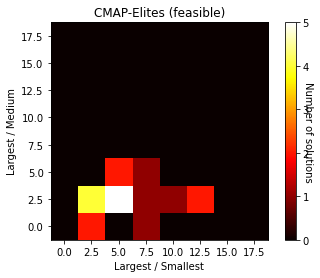

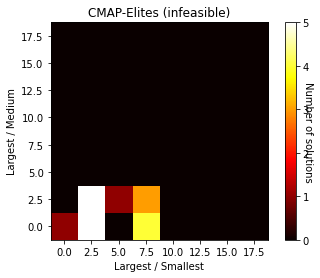

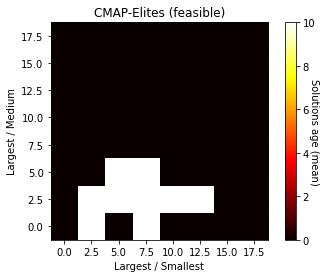

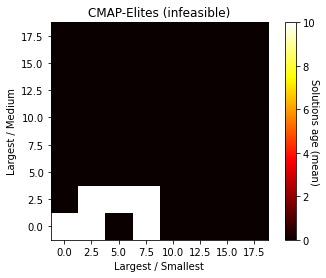

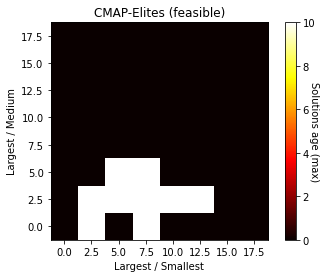

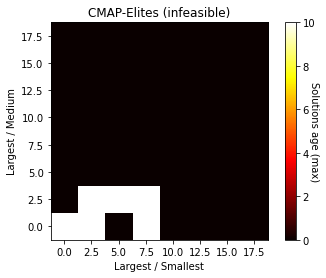

In [18]:
mapelites.generate_initial_populations(lsystem=lsystem,
                                       pops_size=20,
                                       n_retries=100)

# mapelites.show_fitness(show_mean=True,
#                        population='feasible')
# mapelites.show_fitness(show_mean=False,
#                        population='feasible')
# mapelites.show_fitness(show_mean=True,
#                        population='infeasible')
# mapelites.show_fitness(show_mean=False,
#                        population='infeasible')
mapelites.show_coverage(population='feasible')
mapelites.show_coverage(population='infeasible')
mapelites.show_age(show_mean=True,
                   population='feasible')
mapelites.show_age(show_mean=True,
                   population='infeasible')
mapelites.show_age(show_mean=False,
                   population='feasible')
mapelites.show_age(show_mean=False,
                   population='infeasible')

  0%|          | 0/5 [00:00<?, ?it/s]

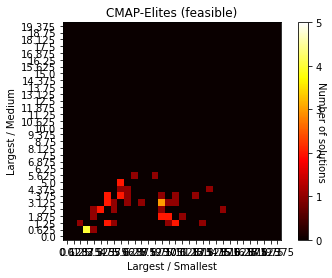

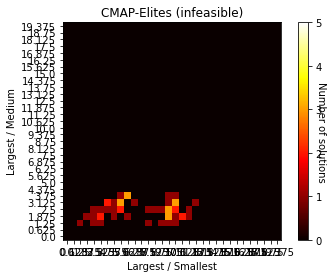

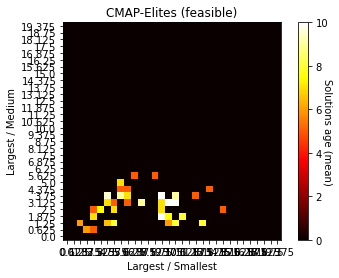

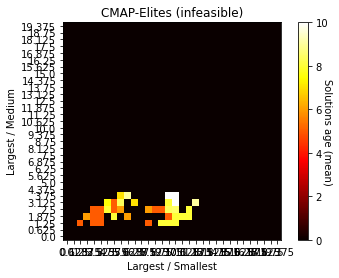

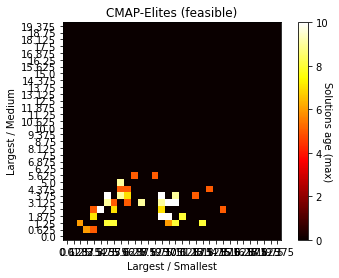

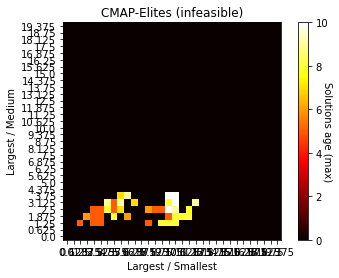

In [19]:
for i in trange(5):
    mapelites.rand_step(gen=i)

# mapelites.show_fitness(show_mean=True,
#                        population='feasible')
# mapelites.show_fitness(show_mean=False,
#                        population='feasible')
# mapelites.show_fitness(show_mean=True,
#                        population='infeasible')
# mapelites.show_fitness(show_mean=False,
#                        population='infeasible')
mapelites.show_coverage(population='feasible')
mapelites.show_coverage(population='infeasible')
mapelites.show_age(show_mean=True,
                   population='feasible')
mapelites.show_age(show_mean=True,
                   population='infeasible')
mapelites.show_age(show_mean=False,
                   population='feasible')
mapelites.show_age(show_mean=False,
                   population='infeasible')